### Analyse non supervisée du dataset de santé mentale

#### Objectif

L’objectif de cette analyse est d’explorer un dataset lié à la santé mentale afin de :
- Identifier automatiquement des **groupes d’individus ayant des profils psychologiques ou comportementaux similaires**
- Comprendre si ces groupes sont associés à des **niveaux de risque en santé mentale** (`mental_health_risk`)
- Visualiser les regroupements obtenus et les interpréter de manière compréhensible

#### Méthodes utilisées

Pour atteindre cet objectif, nous avons appliqué plusieurs techniques d’analyse non supervisée :
- **Clustering** : K-Means (principalement), avec comparaison sur différentes valeurs de `k`
- **Évaluation des regroupements** : scores de Silhouette, Calinski-Harabasz, Davies-Bouldin
- **Réduction de dimension** : ACP (PCA) pour visualiser les clusters en 2D
- **Analyse croisée** : étude de la répartition du niveau de risque par cluster et identification des variables les plus importantes dans chaque groupe

Cette approche permet d’**interpréter les profils identifiés**, de **mettre en évidence les plus vulnérables**, et d’envisager des **actions ciblées** à partir des résultats du clustering.


In [68]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
    
# Importer toutes les fonctions nécessaires
from process_data_clustering import (
    visualiser_donnees,
    preprocess_data,
    scale_features,
    pca_reduction,
    apply_kmeans,
    entrainer_kmeans_multiples,
    visualiser_scores,
    top_features_par_cluster,
    evaluate_clustering,
    elbow_method,
    plot_elbow,
    visualiser_clusters_pca,
    analyse_risque_par_cluster,
    analyser_clusters_complet
)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import process_data_clustering as mh
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Configuration de l'affichage
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)



##  Chargement et visualisations des données

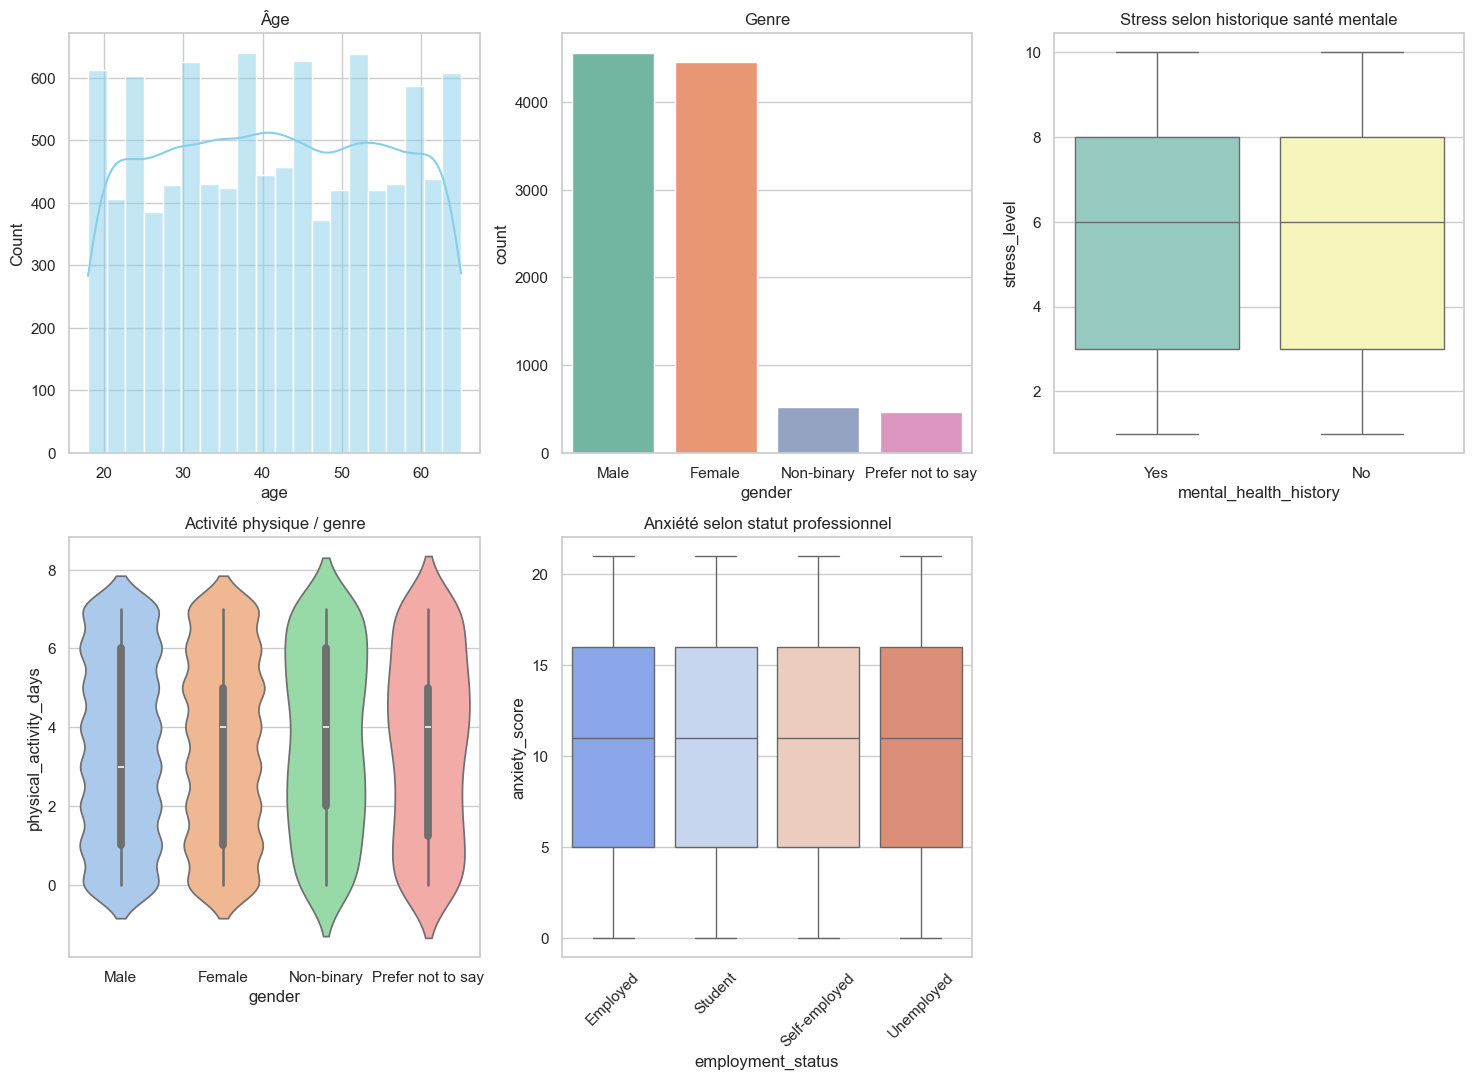

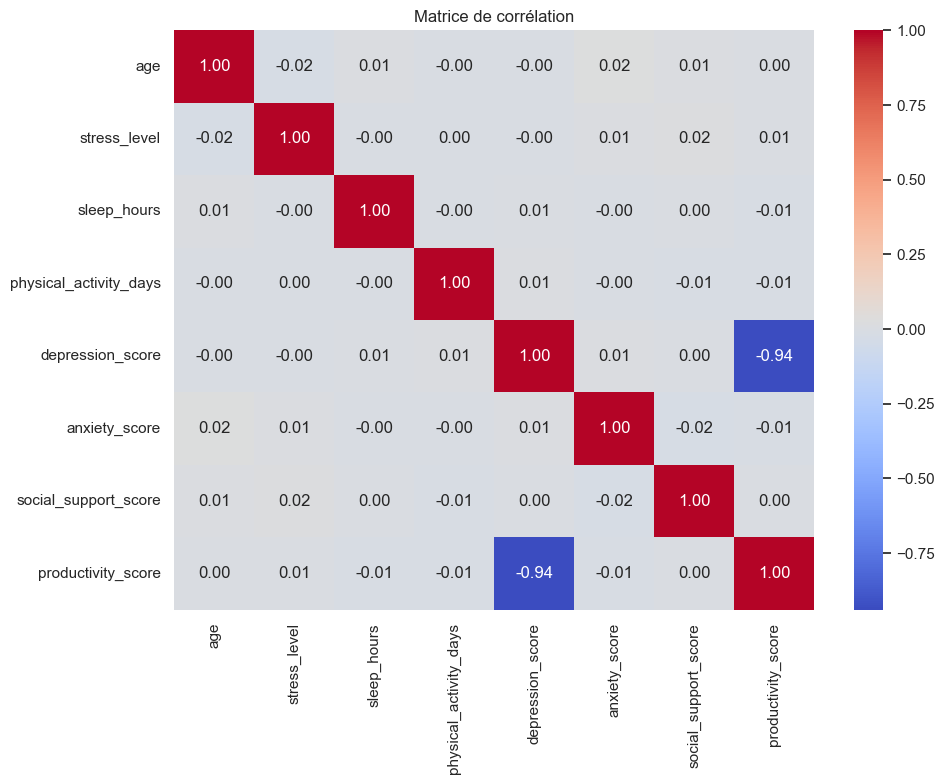

In [69]:
df = pd.read_csv("mental_health_dataset.csv")  # charger le fichier CSV
mh.visualiser_donnees(df)

#### Remarques : 
Avant de lancer l’analyse, on a exploré les données pour mieux comprendre leur structure.

On a observé que la majorité des répondants avaient entre 20 et 40 ans, et que la base était composée principalement d’hommes et de femmes et très peu de non binaire et non renseigné donc on peut simplifier en gardant que les hommes et femmes
Les boxplots ont permis de repérer que le stress était élevé dans l’ensemble, indépendamment de l’historique de santé mentale.

On remarque aussi que les niveaux d’anxiété ne varient pas selon le statut professionnel

Enfin, la matrice de corrélation a mis en évidence une relation forte entre dépression et productivité (corrélation négative)

Ces éléments nous ont guidés dans le choix des variables à utiliser pour le clustering.Étant donné que `depression_score` et `productivity_score` sont très fortement corrélés (-0.94), on a choisi de ne garder que `depression_score` pour l’analyse. Cela évite une redondance dans les variables utilisées pour le clustering, et permet de se concentrer sur les aspects psychologiques directs plutôt que sur les conséquences comportementales comme la productivité.

### Préparation des données
#####  Pré-traitement des données

Avant d'appliquer les algorithmes de machine learning, les données brutes ont été nettoyées et préparées à l'aide de la fonction `preprocess_data`. Cette étape de pré-traitement est essentielle pour garantir la qualité des résultats. Elle comprend les étapes suivantes :

1. **Suppression des valeurs manquantes**  
   Toutes les lignes contenant au moins une valeur manquante sont supprimées afin d'éviter les biais ou erreurs lors de l'analyse.

2. **Filtrage des genres**  
   Pour simplifier l'encodage et l'interprétation des résultats, seuls les individus ayant indiqué leur genre comme **"Male"** ou **"Female"** sont conservés. Les autres réponses sont exclues.

3. **Encodage du genre**  
   Le genre est converti en format numérique binaire :
   - `0` pour les hommes  
   - `1` pour les femmes

4. **Encodage des variables catégorielles**  
   Les colonnes `employment_status` (statut professionnel) et `work_environment` (environnement de travail) sont encodées automatiquement en codes numériques via `pandas.Categorical`. Cela permet de transformer les catégories textuelles en valeurs entières exploitables par les algorithmes.

5. **Encodage des variables booléennes**  
   Les réponses "Yes"/"No" des colonnes `mental_health_history` (antécédents de santé mentale) et `seeks_treatment` (recherche de traitement) sont transformées en valeurs binaires :
   - `1` pour "Yes"  
   - `0` pour "No"

Ce traitement permet d’obtenir un DataFrame propre, homogène et entièrement numérique, prêt à être normalisé et utilisé pour le clustering et la détection d’anomalies.


In [70]:
df = mh.preprocess_data(df)
df.head()

,age,gender,employment_status,work_environment,mental_health_history,seeks_treatment,stress_level,sleep_hours,physical_activity_days,depression_score,anxiety_score,social_support_score,productivity_score,mental_health_risk
0,56,0,0,1,1,1,6,6.2,3,28,17,54,59.7,High
1,46,1,2,1,0,1,10,9.0,4,30,11,85,54.9,High
2,32,1,0,1,1,0,7,7.7,2,24,7,62,61.3,Medium
4,25,1,1,1,1,1,3,5.4,0,24,12,70,69.0,High
5,38,1,3,1,1,1,3,9.9,3,17,9,63,69.3,Medium


### Normalisation des variables numériques

Avant d’appliquer les algorithmes de clustering, on a commencé par normaliser les données, grâce à la fonction `scale_features`. C’est une étape importante car certains algorithmes comme K-Means ou PCA utilisent des calculs de distance, et donc peuvent être influencés si certaines colonnes ont des valeurs beaucoup plus grandes que d’autres.

Pour éviter ce problème, on a utilisé `StandardScaler` (de la bibliothèque scikit-learn), qui transforme chaque variable de manière à ce qu’elle ait :
- une moyenne égale à 0
- un écart-type égal à 1

Grâce à cette transformation, toutes les variables ont le même poids dans les calculs.

##### Quelles variables ont été normalisées ?

On a sélectionné uniquement des colonnes numériques ou bien encodées en chiffres, comme :

- `age`
- `gender`
- `employment_status`
- `work_environment`
- `mental_health_history`
- `seeks_treatment`
- `stress_level`
- `sleep_hours`
- `physical_activity_days`
- `depression_score`
- `anxiety_score`
- `social_support_score`

Ces colonnes ont été choisies car elles décrivent le mode de vie, l’état psychologique ou les comportements des personnes, et qu’elles peuvent être utilisées directement dans les modèles sans transformation supplémentaire.

##### Pourquoi on n’a pas inclus `mental_health_risk` ?

Même si `mental_health_risk` est une variable importante, elle n’a pas été utilisée dans la phase de clustering. L’idée, ici, était de découvrir des groupes de personnes en fonction de leurs caractéristiques, puis d’analyser ensuite si ces groupes correspondent à un niveau de risque particulier.

Inclure directement `mental_health_risk` dans l’algorithme aurait faussé les regroupements, car cette variable résume déjà d’autres informations. On la garde donc pour l’analyse après le clustering, par exemple pour voir si un certain groupe contient surtout des personnes à "haut risque".


In [71]:
feature_cols = [
    'age', 'gender', 'employment_status', 'work_environment',
    'mental_health_history', 'seeks_treatment', 'stress_level',
    'sleep_hours', 'physical_activity_days', 'depression_score',
    'anxiety_score', 'social_support_score'
]
X_scaled = mh.scale_features(df, feature_cols)


### Clustering avec l’algorithme K-Means

L’algorithme K-Means est une méthode de clustering non supervisé qui permet de regrouper des individus similaires dans des groupes appelés **clusters**.

Concrètement, on choisit un nombre de clusters `k`, puis l’algorithme :
1. Place `k` centres (appelés centroïdes) de manière aléatoire dans l’espace des données.
2. Associe chaque point de données au centre le plus proche.
3. Recalcule les centres en prenant la moyenne des points assignés à chaque cluster.
4. Répète les étapes jusqu’à stabilisation (quand les centres ne bougent plus beaucoup).

La fonction `apply_kmeans` utilise cette méthode pour regrouper les individus en fonction de leurs caractéristiques (après normalisation).  
Elle renvoie pour chaque individu une **étiquette** de cluster (`labels`) et le **modèle entraîné**, ce qui permet d’analyser les groupes formés.




### Méthode du coude pour déterminer le bon nombre de clusters

Avant d’appliquer K-Means, il faut choisir combien de groupes (`k`) on veut former.  
Mais ce choix n’est pas toujours évident. C’est pour cela qu’on utilise la **méthode du coude** (*elbow method*), qui aide à estimer la **valeur optimale de k**.

La fonction `elbow_method` teste plusieurs valeurs de `k` (par exemple de 2 à 10), et pour chacune, elle entraîne un modèle K-Means et calcule son **inertie intra-cluster**.

#### Qu’est-ce que l’inertie ?
L’inertie représente la **somme des distances entre chaque point et le centre de son cluster**. Plus cette valeur est faible, plus les points sont proches de leur centre, donc mieux regroupés.

#### Comment interpréter le graphique ?
En traçant l’inertie en fonction de `k`, on observe généralement une courbe qui **diminue rapidement au début**, puis **se stabilise**.  
Le point où la diminution devient moins forte forme un **"coude"**. Ce coude correspond souvent au **meilleur choix de k**, car :
- Avant ce point : chaque cluster ajouté améliore beaucoup la qualité
- Après ce point : ajouter des clusters n’apporte presque plus de gain




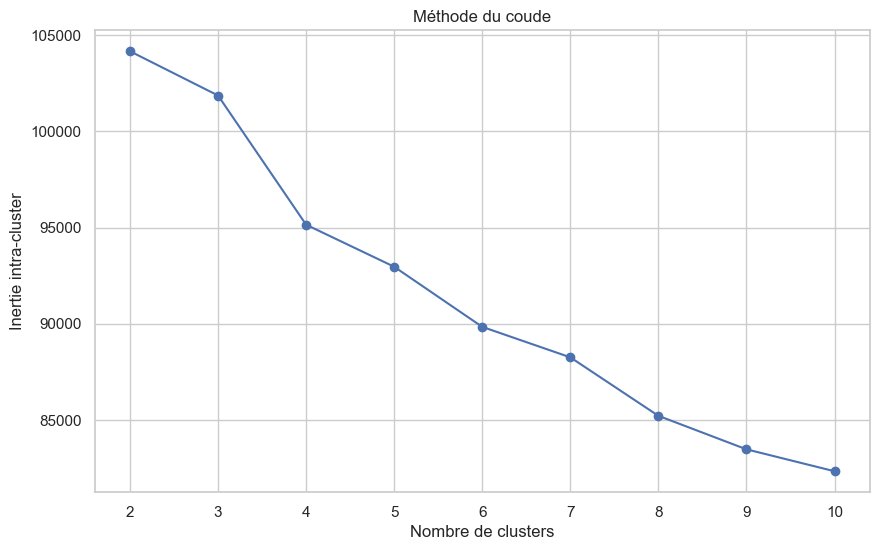

In [55]:
inertias = mh.elbow_method(X_scaled, max_k=10)
mh.plot_elbow(inertias)

Dans notre cas, le coude semble apparaître autour de **k = 4** :
- Avant ce point, l’inertie chute rapidement.
- Après, la courbe devient plus plate, ce qui signifie que **rajouter des clusters n’apporte plus beaucoup d’amélioration**.

 **Conclusion :** le choix de **4 clusters** semble être le meilleur.


### Entraînement de plusieurs modèles K-Means avec évaluation

Dans cette étape, on a testé plusieurs modèles K-Means avec différents nombres de clusters (`k`) pour voir lequel donne les meilleurs résultats. Comme on ne sait pas à l’avance combien de groupes il faut, on essaie plusieurs possibilités, par exemple entre 2 et 10.

Même si la méthode du coude peut donner une première idée (par exemple k = 4 dans notre cas), on ne souhaite pas se baser uniquement sur elle. On préfère **tester plusieurs valeurs de `k`** et les **évaluer avec des scores plus précis** pour choisir la solution la plus pertinente.

Pour chaque `k`, on entraîne un modèle K-Means, puis on mesure la qualité du regroupement à l’aide de trois scores complémentaires :

- **Silhouette score** : mesure si les points sont bien regroupés et bien séparés.  
  Il varie entre -1 et 1 :
  - proche de 1 → clusters bien définis
  - proche de 0 → clusters peu clairs
  - négatif → regroupement probablement mauvais

- **Calinski-Harabasz score** : plus il est élevé, mieux les clusters sont séparés les uns des autres.

- **Davies-Bouldin score** : ici, plus le score est petit, mieux c’est (clusters compacts et bien distincts).

On enregistre tous les résultats (modèle, labels et scores) pour les **comparer ensuite** et choisir le meilleur `k` en se basant sur plusieurs critères, et pas seulement un graphique. Cela rend le choix plus fiable et justifié.


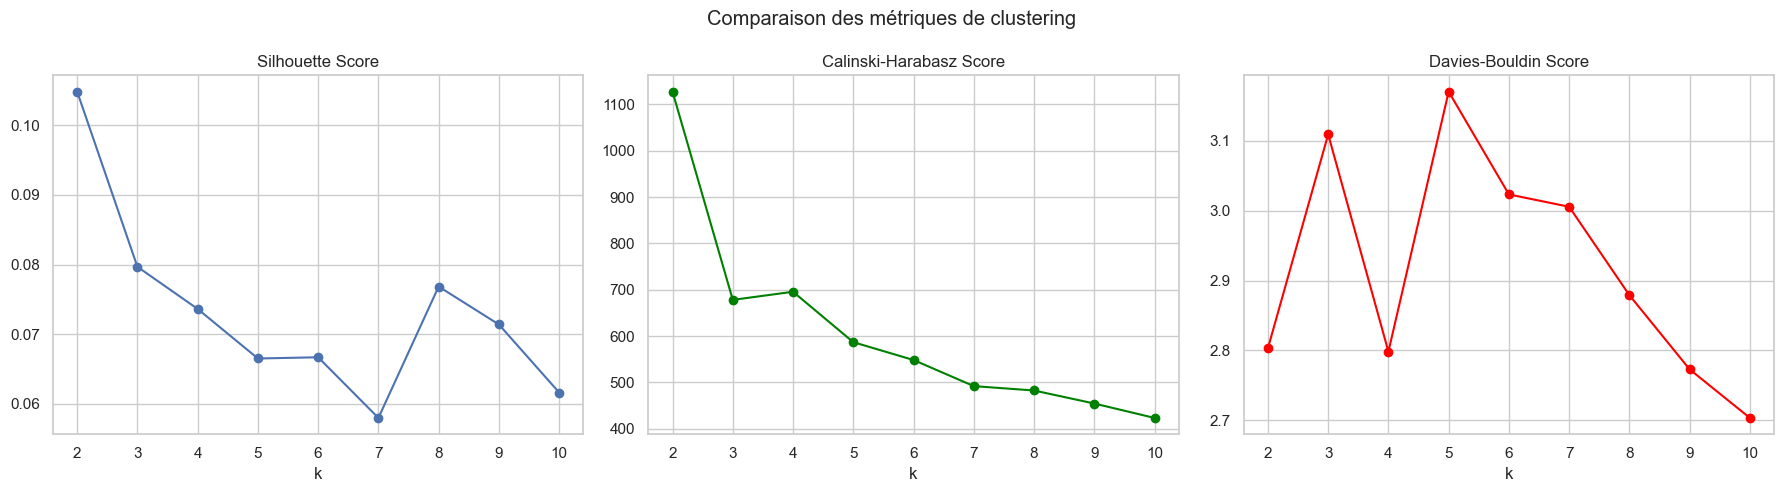

In [57]:
resultats = entrainer_kmeans_multiples(X_scaled, k_range=range(2, 11))
# Affiche les graphes pour comparer les scores
visualiser_scores(resultats)


####  Visualisation PCA des clusters


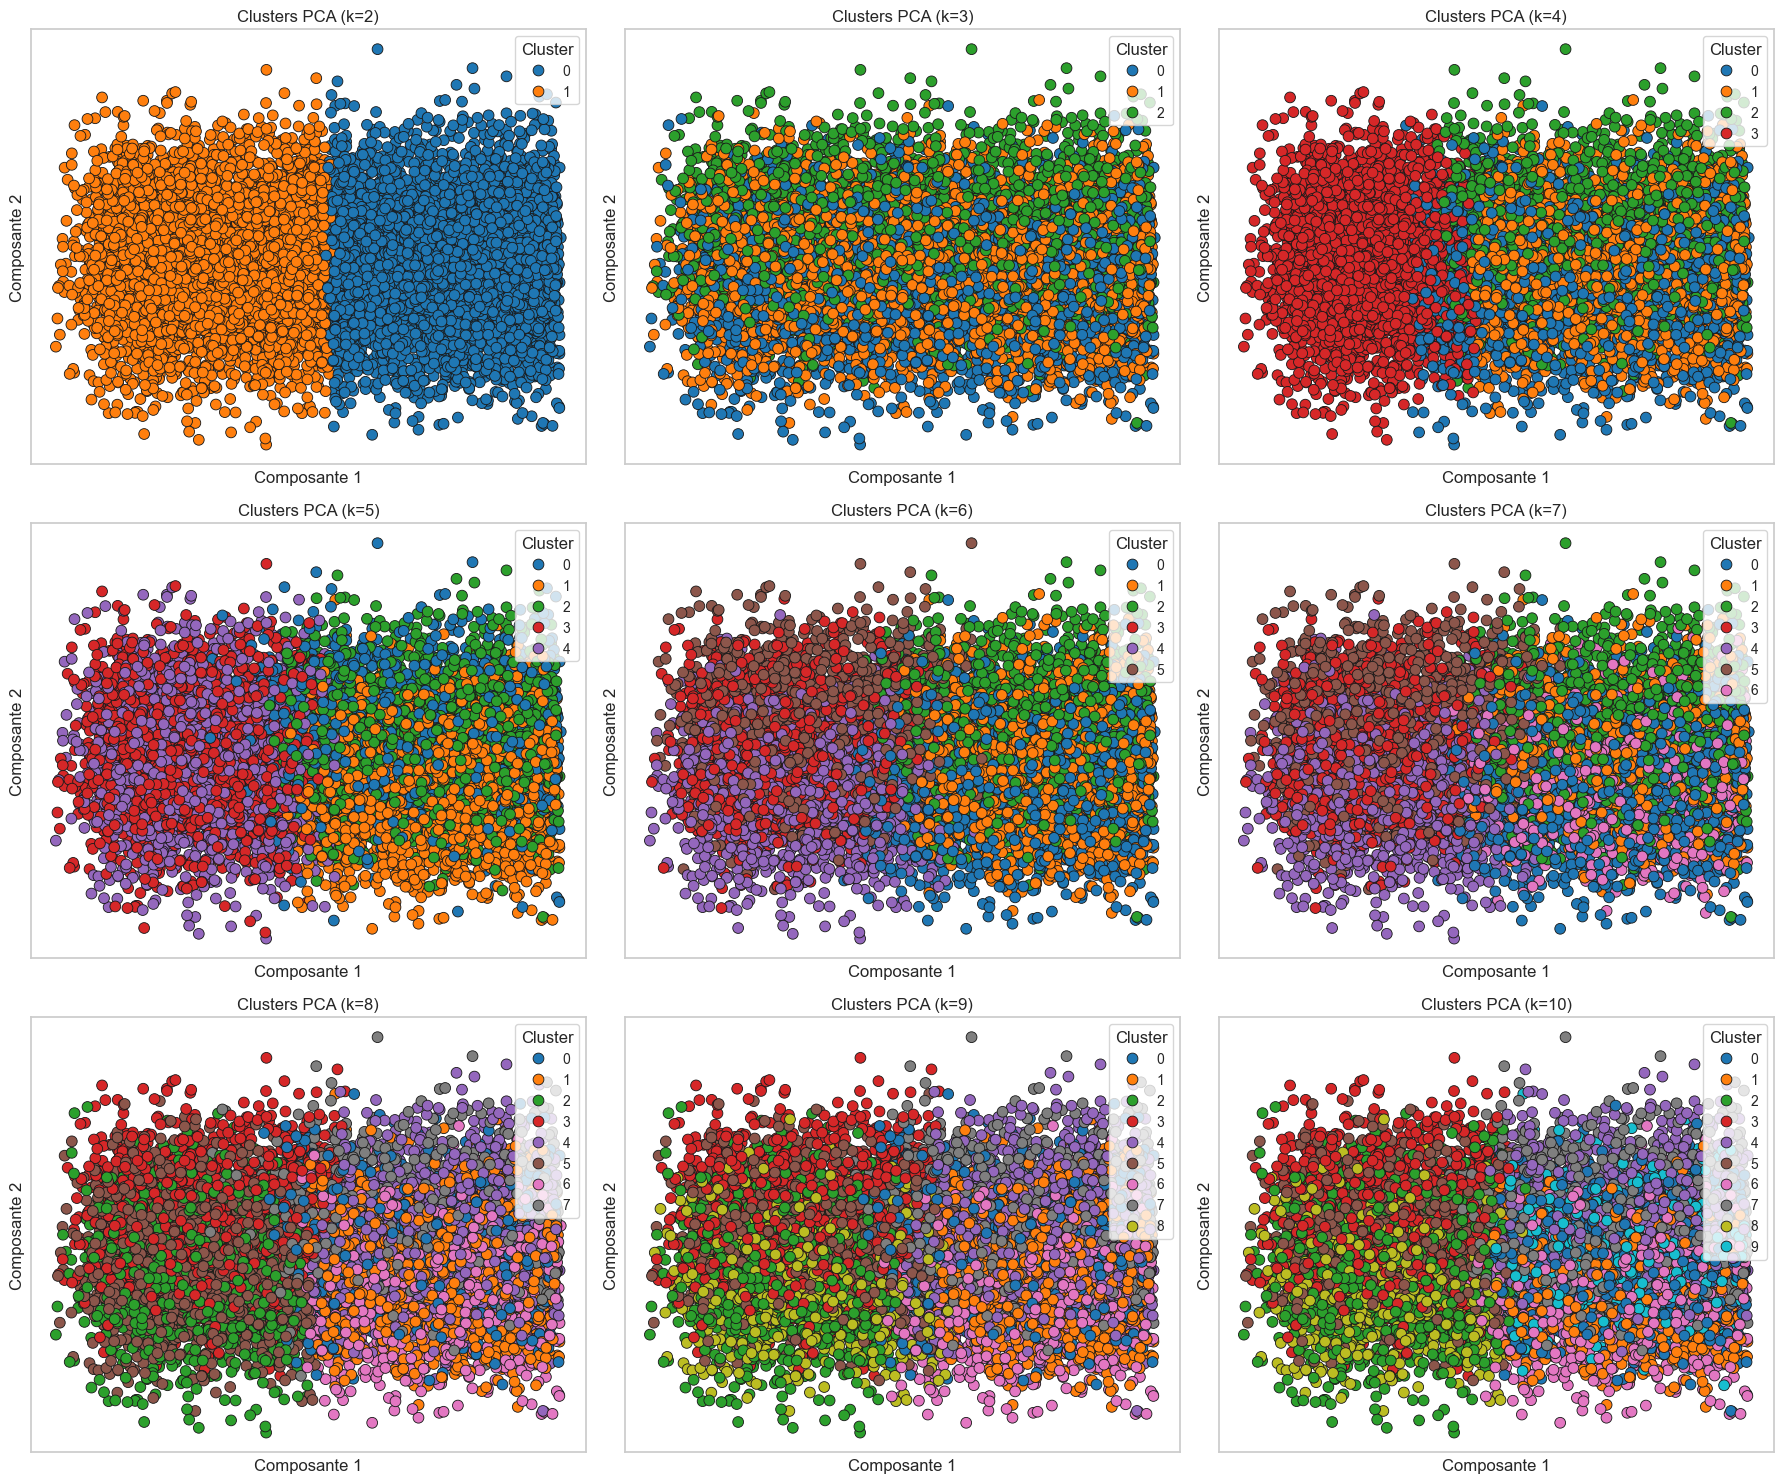

In [60]:
# Visualisation des clusters avec PCA
visualiser_clusters_pca(resultats, X_scaled)

#### Conclusion : 
Même si la méthode du coude suggérait k = 4, l’évaluation par les scores montre que **k = 2** donne des résultats très bons sur les trois métriques.  
Cependant, un nombre de clusters trop faible peut **masquer des sous-groupes intéressants**.

**Nous retenons donc k = 4 comme un bon compromis**, car :
- Il est appuyé par la méthode du coude
- Il permet une segmentation plus fine qu’un simple découpage binaire
- Il reste cohérent avec les scores obtenus, notamment pour Silhouette et Davies-Bouldin


### Analyse des clusters par rapport au niveau de risque 

Une fois les groupes (ou clusters) formés grâce à l’algorithme K-Means, l’objectif est d’analyser si ces groupes correspondent à différents niveaux de risque en santé mentale (`mental_health_risk`). Pour cela, on a associé à chaque individu son cluster et son niveau de risque.

Ensuite, on a observé la répartition des niveaux de risque dans chaque cluster. Cette analyse permet de voir, par exemple, si un cluster est majoritairement composé de personnes à "haut risque", ou au contraire, s’il regroupe surtout des profils à "faible risque".

Cela nous aide à **donner du sens aux groupes formés** : on ne se contente pas de regrouper les individus selon leurs caractéristiques, on cherche aussi à savoir si ces regroupements sont liés à une variable importante du domaine, ici le risque en santé mentale.

Cette étape est essentielle car elle permet de vérifier si les clusters obtenus sont pertinents sur le plan pratique, et si l’algorithme a réussi à faire ressortir des profils typiques à partir des données.
    

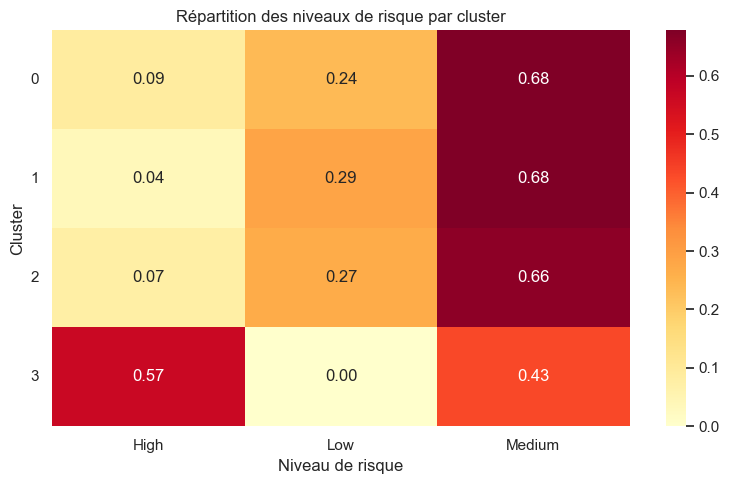

Top features par cluster :
Cluster 0 : ['mental_health_history', 'depression_score', 'stress_level', 'gender', 'seeks_treatment']
Cluster 1 : ['seeks_treatment', 'depression_score', 'mental_health_history', 'employment_status', 'physical_activity_days']
Cluster 2 : ['seeks_treatment', 'mental_health_history', 'depression_score', 'social_support_score', 'work_environment']
Cluster 3 : ['depression_score', 'mental_health_history', 'seeks_treatment', 'social_support_score', 'employment_status']


In [73]:

# labels = résultats du KMeans
# X_scaled = données normalisées
# feature_cols = liste des colonnes utilisées
# df = DataFrame original contenant 'mental_health_risk'

meilleur_resultat = resultats[2]  # par exemple, index pour k=4 (k=2 → index 0)
labels = meilleur_resultat['labels']

# On donne les noms de tes features dans le même ordre que X_scaled
feature_names = [
    'age', 'gender', 'employment_status', 'work_environment',
    'mental_health_history', 'seeks_treatment', 'stress_level',
    'sleep_hours', 'physical_activity_days', 'depression_score',
    'anxiety_score', 'social_support_score'
]

tableau_risque, top_features = analyser_clusters_complet(
    df=df,
    labels=labels,
    X_scaled=X_scaled,
    feature_names=feature_cols,
    afficher_heatmap=True,
    top_n=5
)

# Affichage facultatif
print("Top features par cluster :")
for cluster, features in top_features.items():
    print(f"Cluster {cluster} : {features}")



Après avoir formé les clusters à l’aide de l’algorithme K-Means, nous avons cherché à savoir si ces groupes correspondaient à des niveaux de risque différents en santé mentale (`mental_health_risk`). La heatmap ci-dessus montre la répartition des niveaux de risque (`High`, `Medium`, `Low`) dans chaque cluster.

#### Observations principales :
- Les clusters **0, 1 et 2** présentent une forte majorité d’individus à **risque moyen** (plus de 65 % dans chaque cas).
- Le **cluster 3** se démarque avec **57 % d’individus à haut risque**, contre seulement 43 % à risque moyen, et 0 % à faible risque. Ce groupe représente donc un profil particulièrement vulnérable.
- Aucun cluster n’est majoritairement composé de profils à faible risque.

#### Analyse des caractéristiques des clusters :
En croisant cette répartition avec les **top features par cluster**, on peut mieux comprendre les profils dominants :
- **Cluster 3**, qui regroupe les profils les plus à risque, est fortement associé à des **scores élevés de dépression**, à une **faible productivité**, et à un **manque de soutien social**.
- **Cluster 0**, bien que composé à 68 % de personnes à risque moyen, est marqué par un historique de santé mentale, un stress élevé et des scores de dépression.
- Les clusters 1 et 2, également dominés par le risque moyen, présentent des combinaisons différentes mais impliquent souvent la recherche de traitement et un historique psychologique.

#### Conclusion :
Cette analyse montre que le clustering a permis de faire ressortir des **profils types liés aux niveaux de risque**. Le fait que certains groupes soient composés majoritairement de personnes à haut risque (notamment le cluster 3) confirme l’utilité de cette méthode pour **identifier des populations vulnérables**, pouvant faire l’objet d’un accompagnement ciblé.


In [56]:
# Entrainement pour k=4
kmeans_labels, kmeans_model = mh.apply_kmeans(X_scaled, n_clusters=4)
df['kmeans_cluster'] = kmeans_labels
sil, cal, db = mh.evaluate_clustering(X_scaled, kmeans_labels)
print(f"Silhouette: {sil:.3f}, Calinski-Harabasz: {cal:.1f}, Davies-Bouldin: {db:.3f}")


Silhouette: 0.074, Calinski-Harabasz: 695.5, Davies-Bouldin: 2.798


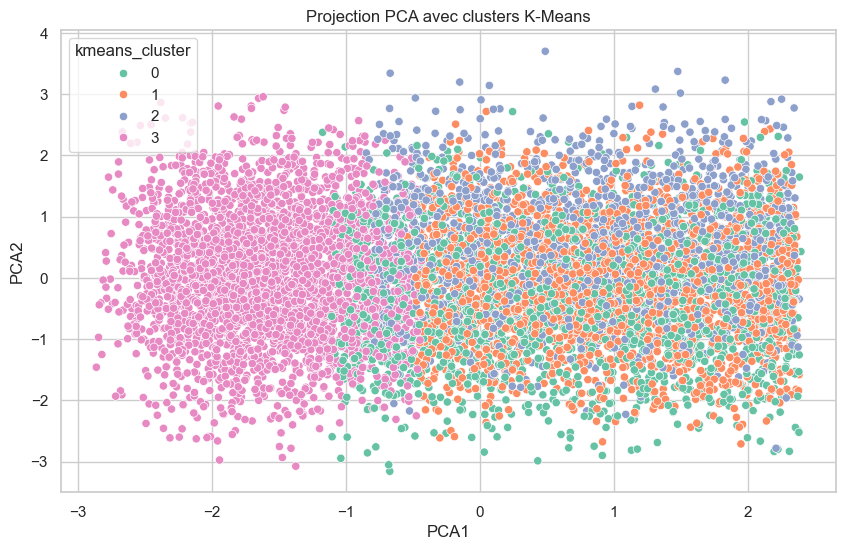

In [46]:
X_pca = mh.pca_reduction(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='kmeans_cluster', palette='Set2')
plt.title("Projection PCA avec clusters K-Means")
plt.show()